In [11]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pymc as pm
import arviz as az
import xarray as xr
from sklearn.preprocessing import StandardScaler
import statsmodels.graphics.tsaplots as smg
import pytensor
import pytensor.tensor as pt
from pymc.pytensorf import collect_default_updates
import pandas as pd
from sklearn.preprocessing import StandardScaler


az.style.use("arviz-darkgrid")

settings = {'figure.figsize':(14,4),
            'figure.dpi':144,
            'figure.facecolor':'w',
            'axes.spines.top':False,
            'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.grid':True,
            'grid.linestyle':'--',
            'grid.linewidth':0.5, 
            'figure.constrained_layout.use':True}
plt.rcParams.update(settings)

In [12]:
# get data     
data = pd.read_csv(r"../data/a0_combinedQuarterly_new.csv", index_col=[0])
data = data['gdp_total_season'].to_frame()
data['gdp_total_season_diff'] = data['gdp_total_season'].diff()
data.dropna(inplace=True)


### Standardize

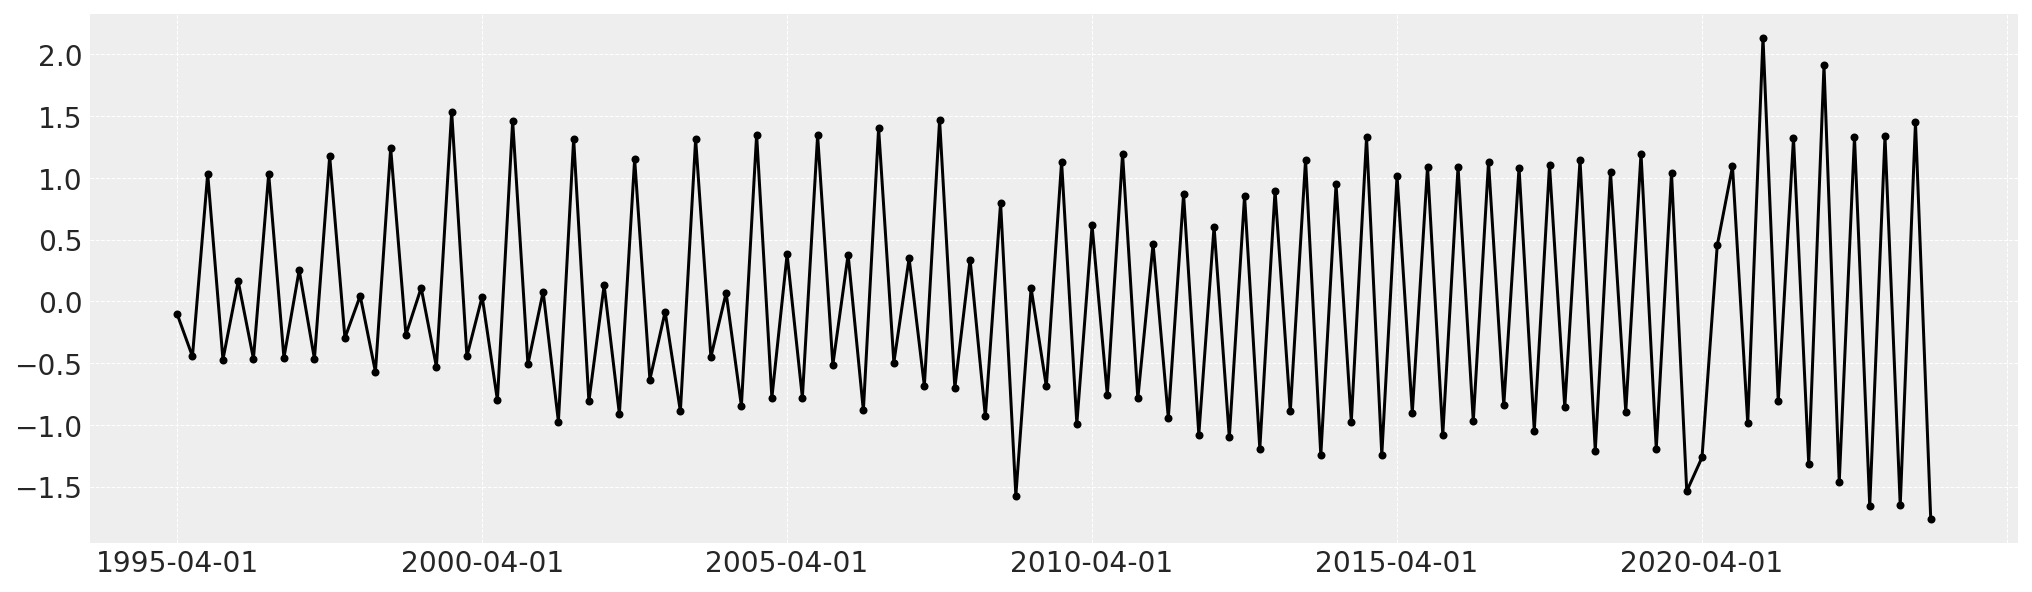

In [13]:
scaler = StandardScaler()

columns_Transform = ["gdp_total_season_diff"]
data[columns_Transform] = scaler.fit_transform(data[columns_Transform])
data.columns = [cls + "_stdz" for cls in data.columns]
data['gdp_total_season_diff_stdz'].plot(style=".-", color="k");

y = data


$$
y_t = \rho_0 + \rho_1 y_{t-1} + \rho_2 y_{t-2} + \epsilon_t 
$$


#### A "for" loop is necessary as can be seen by interating an AR1 backwards k times we get: 
$
\\
y_t = \rho y_{t-1} + \epsilon_t \\
y_{t-1} = \rho y_{t-2} + \epsilon_{t-1} \\
y_{t-2} = \rho y_{t-3} + \epsilon_{t-2} \\
y_{t-k} = \rho y_{t-(k-1)} + \epsilon_{t-k}  \\
\vdots \\
y_t = \rho^k y_{t-k} + \sum_{j=0}^{k-1} \rho^j \epsilon_{t-j}
$

######################################################################################

## Defining AR2 model in PyMC with Scan

In [14]:
# https://gist.github.com/ricardoV94/a49b2cc1cf0f32a5f6dc31d6856ccb63#file-pymc_timeseries_ma-ipynb

seed = sum(map(ord, "GDP+AR(2)"))
rng = np.random.default_rng(seed)

In [15]:
lags = 2
trials = 117

def ar_dist(ar_init, rho, sigma, size):
    
    def ar_step(x_tm2, x_tm1, rho, sigma):
        mu = x_tm1 * rho[0] + x_tm2 * rho[1]
        x = mu + pm.Normal.dist(sigma=sigma)
        return x, collect_default_updates([x])
    
    ar_innov, _ = pytensor.scan(
        fn=ar_step,
        outputs_info=[{"initial": ar_init, "taps":range(-lags, 0)}],
        non_sequences=[rho, sigma],
        n_steps=trials-lags,
        strict=True,
    )
    
    return ar_innov

coords = {
    "lags": range(-lags, 0),
    "steps": range(trials - lags),
    "trials": range(trials),
}

with pm.Model(coords=coords, check_bounds=False) as m:
    
    rho = pm.Normal("rho", mu=0, sigma=0.2, dims=("lags",))
    sigma = pm.HalfNormal("sigma", sigma=.2)
    
    ar_init_obs = pm.MutableData("ar_init_obs", np.zeros(lags), dims=("lags",))
    ar_init = pm.Normal("ar_init", observed=ar_init_obs, dims=("lags",))

    ar_innov_obs = pm.MutableData("ar_innov_obs", y[trials-lags], dims=("steps",))
    ar_innov = pm.CustomDist(
        "ar_dist",
        ar_init,
        rho, 
        sigma,
        dist=ar_dist,
        observed=ar_innov_obs,
        dims=("steps",)
    )
        
    ar = pm.Deterministic("ar", pt.concatenate([ar_init, ar_innov], axis=-1), dims=("trials",))

/home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


KeyError: 115

In [ ]:
y

In [ ]:
lags

In [ ]:
pm.model_to_graphviz(m)

In [ ]:
with m:
    prior = pm.sample_prior_predictive(
        samples=120,
        random_seed=rng,
    )

In [ ]:
for hdi_prob in (0.94, 0.64):
    hdi = az.hdi(prior.prior["ar"], hdi_prob=hdi_prob)["ar"]
    lower=hdi.sel(hdi="lower")
    upper=hdi.sel(hdi="higher")
    plt.fill_between(np.arange(trials), y1=lower, y2=upper, alpha=.2, color="C0")
plt.plot(prior.prior["ar"].mean(("chain", "draw")), color="C0");

# Prior predictive

In [ ]:
_, ax = plt.subplots(1, 4, figsize=(20, 3), sharey=True)
chosen_draw = 1
for i, axi in enumerate(ax, start=chosen_draw):
    axi.plot(prior.prior["ar"].isel(draw=i, chain=0), color="C0" if i == chosen_draw else "k")

# Posterior Predictive

In [ ]:

prior_draw = prior.prior.isel(chain=0, draw=chosen_draw)

ar_init_obs.set_value(prior_draw["ar"].values[:lags])
ar_innov_obs.set_value(prior_draw["ar"].values[lags:])
ar_obs = prior_draw["ar"].values
rho_true = prior_draw["rho"].values
sigma_true = prior_draw["sigma"].values

print(f"rho_true={np.round(rho_true, 3)}, {sigma_true=:.3f}")

In [ ]:
with m:
    trace = pm.sample(random_seed=rng)

In [ ]:
az.plot_trace(trace, var_names=["rho", "sigma"]);

In [ ]:
az.plot_posterior(trace, var_names=["rho", "sigma"], ref_val=[*rho_true, sigma_true]);

In [ ]:
with m:
    post_pred = pm.sample_posterior_predictive(
        trace, 
        random_seed=rng, 
    )

In [ ]:
post_pred_ar = post_pred.posterior_predictive["ar"]
for hdi_prob in (0.94, 0.64):
    hdi = az.hdi(post_pred_ar, hdi_prob=hdi_prob)["ar"]
    lower = hdi.sel(hdi="lower")
    upper = hdi.sel(hdi="higher")
    plt.fill_between(np.arange(trials), y1=lower, y2=upper, alpha=.2, color="C0")
plt.plot(post_pred_ar.mean(("chain", "draw")), color="C0")    
plt.plot(ar_obs, color="k");

In [ ]:
_, ax = plt.subplots(1, 4, figsize=(20, 3), sharey=True)
for i, axi in enumerate(ax):
    axi.plot(post_pred.posterior_predictive["ar"].isel(draw=i, chain=0), color="C0")

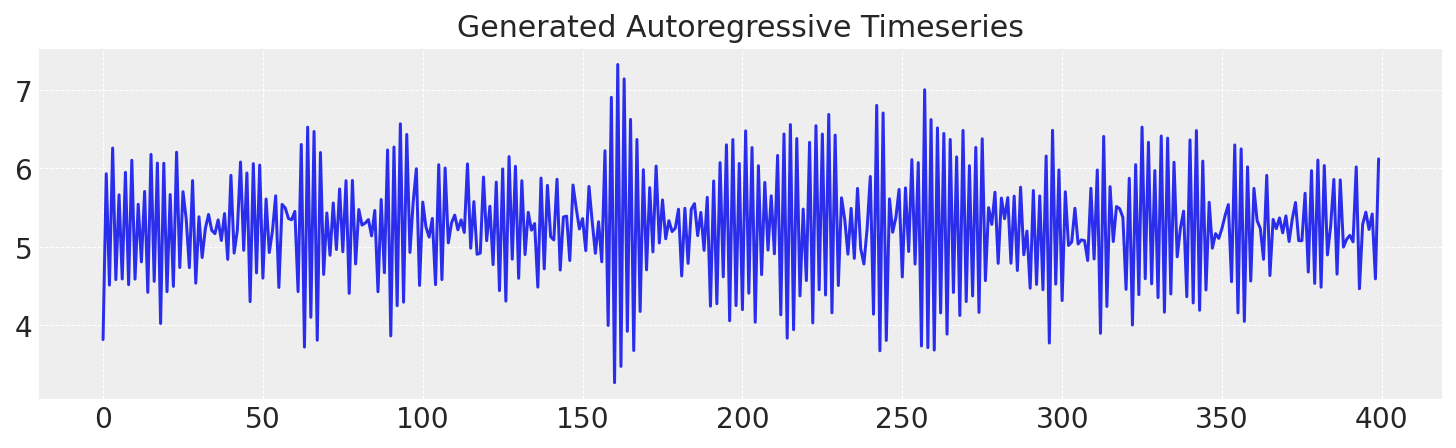

In [8]:
def simulate_ar(intercept, coef1, coef2, noise=0.3, *, warmup=10, steps=200):
    # We sample some extra warmup steps, to let the AR process stabilize
    draws = np.zeros(warmup + steps)
    # Initialize first draws at intercept
    draws[:2] = intercept
    for step in range(2, warmup + steps):
        draws[step] = (
            intercept
            + coef1 * draws[step - 1]
            + coef2 * draws[step - 2]
            + np.random.normal(0, noise)
        )
    # Discard the warmup draws
    return draws[warmup:]


# True parameters of the AR process
ar1_data = simulate_ar(10, -0.9, 0, steps = 200 * 2)

fig, ax = plt.subplots(figsize=(10, 3))
ax.set_title("Generated Autoregressive Timeseries", fontsize=15)
ax.plot(ar1_data)

In [30]:
RANDOM_SEED = 123456
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)
sample_size = 100

n_lags = 1


coords = {
    "n_lags": range(-n_lags, 0),
    "steps": range(trials - lags),
    "rhos": range(0,2),
    "params": range(0,2)
}

with pm.Model(coords=coords) as ar1:
 
    y = pm.MutableData("y", ar1_data, dims="obs_id")
    
    rhos = pm.Normal('rhos', sigma=[1, 0.25], shape=2)
    print(rhos.shape)

    init = pm.Normal('y_init', 0, 10)
    
    # precision of the innovation term
    #sigma = pm.HalfNormal("sigma", 5)

    def ar_step(mu_t, rho):
        mu_tp1 = rho[0] + rho[1] * mu_t
        return mu_tp1

    mu, _ = pytensor.scan(
        ar_step,
        outputs_info=[init],
        non_sequences=rhos,
        n_steps = y.shape[0] - n_lags,
        strict = True
    )

    # --- Need to concat the initial value but the shapes don't match
    mu = pm.Deterministic('mu', pt.concatenate([init[None], mu], axis=0))

     # Analytic steady-state for AR(1) with non-zero constant
    mu_steady = pm.Deterministic('mu_steady', rhos[0] / (1 - rhos[1]))
    sigma = pm.Exponential('sigma', 1)
    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=y)
    prior_idata = pm.sample_prior_predictive()

Sampling: [rhos, sigma, y_hat, y_init]


Shape.0


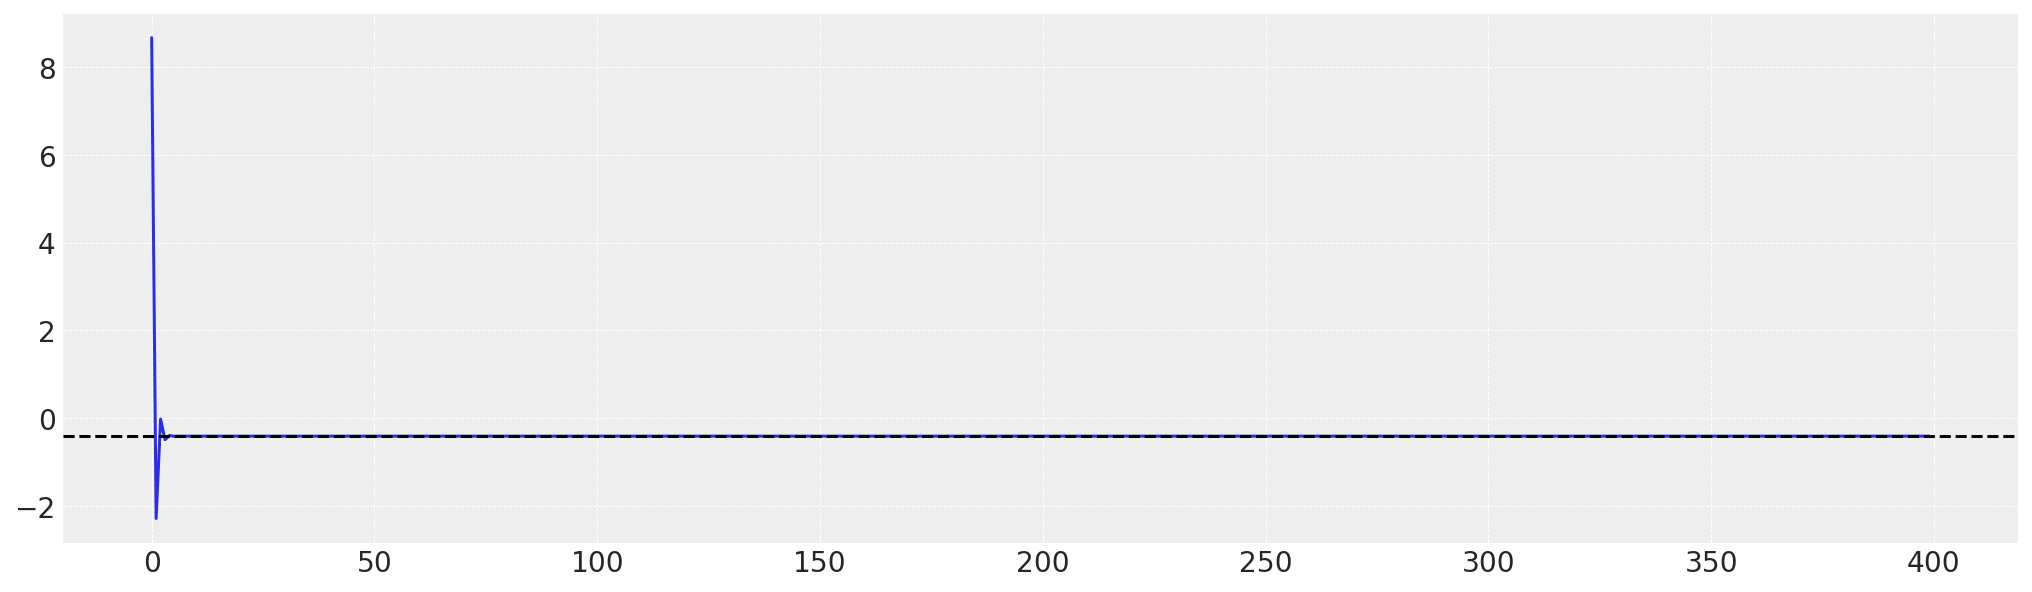

In [31]:
prior = az.extract(prior_idata, 'prior')
idx = np.random.choice(500)
sample = prior.isel(sample=idx)

fig, ax = plt.subplots(figsize=(14,4))
ax.plot(sample.mu)
ax.axhline(sample.mu_steady, ls='--', color='k')